In [1]:
"""
This notebook will study how the number of previously completed sessions 
relates to the quality of embeddings/how well we are able to decode the labels used.
"""

'\nThis notebook will study how the number of previously completed sessions \nrelates to the quality of embeddings/how well we are able to decode the labels used.\n'

In [25]:
import sys
import os # my addtion

import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
import cebra.data
import torch
import cebra.integrations
import cebra.datasets
from cebra import CEBRA
import torch
import pickle

import seaborn as sns
from scipy.stats import pearsonr

from matplotlib.collections import LineCollection
import pandas as pd

## A. Load the sessions stats dataframe

In [26]:
df_sessions_rpe = pickle.load(open('../stats_files/all_session_stats(rpe).pkl', "rb"))

In [27]:
df_sessions_rpe[:100]

,subject_ID,ses_idx,all4_R2_rpe,DA_R2_rpe,NE_R2_rpe,5HT_R2_rpe,ACh_R2_rpe,b4_R2_rpe,af_R2_rpe,ses_idx_count
0,631199,631199_2022-07-12,0.791241,0.219024,0.188226,0.155231,0.337028,0.254467,0.587477,1
1,631198,631198_2022-07-20,0.685341,0.048660,0.032319,0.143145,0.143190,0.120334,0.556137,1
2,631198,631198_2022-07-22,0.767858,0.167233,0.080518,0.079767,0.046843,0.176723,0.612808,2
3,631198,631198_2022-07-14,0.773498,0.112886,0.041683,0.175115,0.078205,0.112344,0.642634,3
4,631198,631198_2022-07-21,0.746688,0.055202,0.013265,0.098098,0.242081,0.069547,0.605273,4
...,...,...,...,...,...,...,...,...,...,...
95,632105,632105_2022-07-21,0.546922,0.335244,0.187420,0.028936,0.015206,0.175503,0.445213,5
96,632104,632104_2022-10-27,0.827005,0.601248,0.689103,0.492040,0.641316,0.512713,0.740297,19
97,632105,632105_2022-07-22,0.749725,0.649731,0.383023,0.076065,0.091184,0.200818,0.637804,6
98,632105,632105_2022-07-23,0.555289,0.482453,0.326993,0.058911,0.092011,0.009270,0.517872,7


## B. Add column showing number of previously completed sessions

In [28]:
df_sessions_rpe['ses_idx_count'] = df_sessions_rpe.groupby('subject_ID').cumcount() + 1

In [29]:
df_sessions_rpe[:100]

,subject_ID,ses_idx,all4_R2_rpe,DA_R2_rpe,NE_R2_rpe,5HT_R2_rpe,ACh_R2_rpe,b4_R2_rpe,af_R2_rpe,ses_idx_count
0,631199,631199_2022-07-12,0.791241,0.219024,0.188226,0.155231,0.337028,0.254467,0.587477,1
1,631198,631198_2022-07-20,0.685341,0.048660,0.032319,0.143145,0.143190,0.120334,0.556137,1
2,631198,631198_2022-07-22,0.767858,0.167233,0.080518,0.079767,0.046843,0.176723,0.612808,2
3,631198,631198_2022-07-14,0.773498,0.112886,0.041683,0.175115,0.078205,0.112344,0.642634,3
4,631198,631198_2022-07-21,0.746688,0.055202,0.013265,0.098098,0.242081,0.069547,0.605273,4
...,...,...,...,...,...,...,...,...,...,...
95,632105,632105_2022-07-21,0.546922,0.335244,0.187420,0.028936,0.015206,0.175503,0.445213,5
96,632104,632104_2022-10-27,0.827005,0.601248,0.689103,0.492040,0.641316,0.512713,0.740297,19
97,632105,632105_2022-07-22,0.749725,0.649731,0.383023,0.076065,0.091184,0.200818,0.637804,6
98,632105,632105_2022-07-23,0.555289,0.482453,0.326993,0.058911,0.092011,0.009270,0.517872,7


## C. Make comparisons of the sessions stats with the ses_idx

Make a simple comparison plot.
Use a colour bar with the session summary plots and check if there's an observable trend.


In [30]:
df_sessions_rpe['DA_R2_rpe'].describe()

count    197.000000
mean       0.580521
std        0.192129
min        0.023339
25%        0.483525
50%        0.633014
75%        0.711367
max        0.862553
Name: DA_R2_rpe, dtype: float64

Text(0.5, 1.0, 'Comparing # sessions done and reconstruction scores')

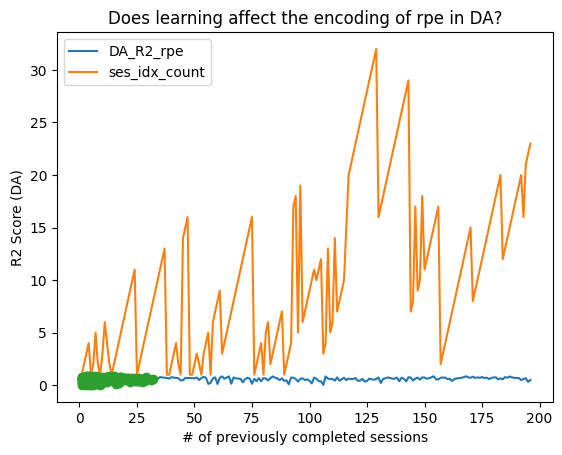

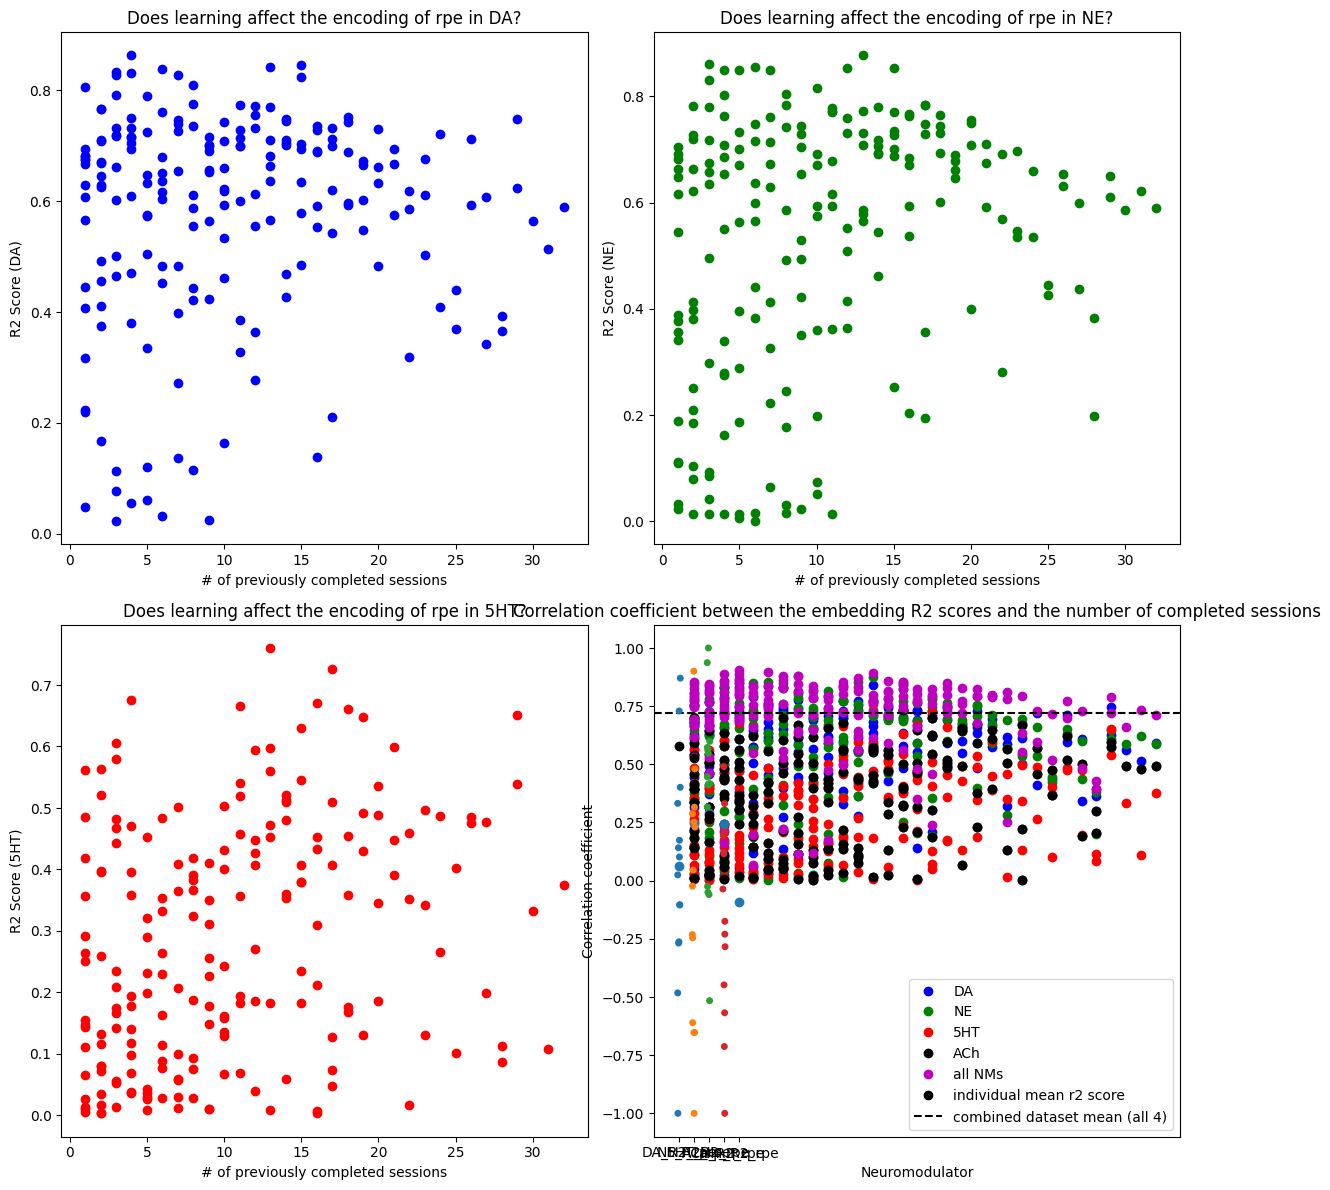

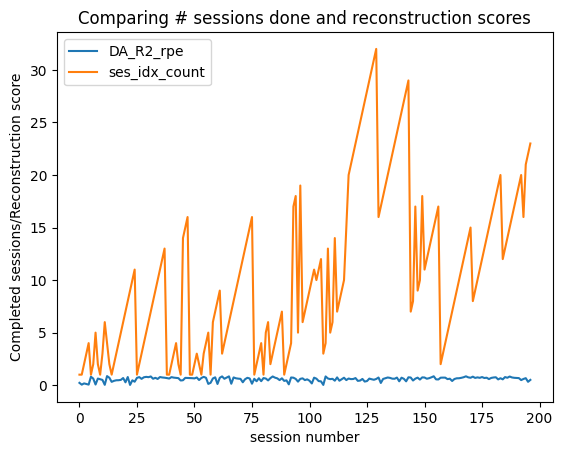

In [31]:
%matplotlib inline
df_sessions_rpe[['DA_R2_rpe','ses_idx_count']].plot()
plt.xlabel('session number')
plt.ylabel('Completed sessions/Reconstruction score')
plt.title('Comparing # sessions done and reconstruction scores')

Text(0.5, 1.0, 'Does learning affect the encoding of rpe in DA?')

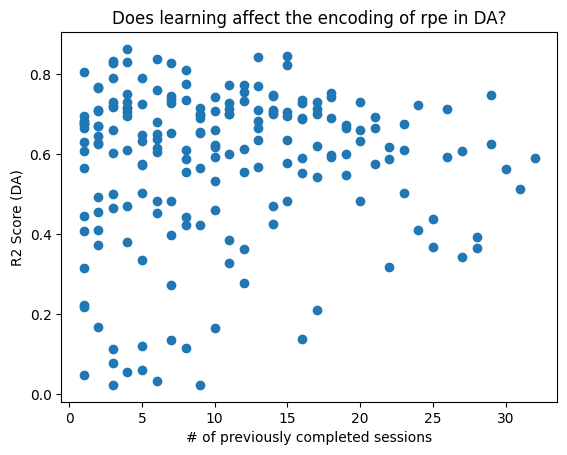

In [32]:
plt.plot(df_sessions_rpe['ses_idx_count'], df_sessions_rpe['DA_R2_rpe'], 'o')
plt.xlabel('# of previously completed sessions')
plt.ylabel('R2 Score (DA)')
plt.title('Does learning affect the encoding of rpe in DA?')

## D. Make summary plot for all the NMS, individually and collectively

In [33]:
# funciton to make the raw plot
def plot_r2_vs_sessions_raw(df, NM):
    # raw plot
    df[['{}_R2_rpe'.format(NM), 'ses_idx_count']].plot()
    plt.xlabel('session number')
    plt.ylabel('Completed sessions/Reconstruction score')
    plt.title('Comparing # sessions done and reconstruction scores ({})'.format(NM))
    plt.show()

In [34]:
def plot_r2_vs_sessions(df, NM_list):

    # create a figure and make the plots
    fig1 = plt.figure(figsize=(12,12))
    gs = gridspec.GridSpec(2, 2, figure=fig1)

    ax1 = fig1.add_subplot(gs[0,0])
    ax2 = fig1.add_subplot(gs[0,1])
    ax3 = fig1.add_subplot(gs[1,0])
    ax4 = fig1.add_subplot(gs[1,1])
    axes = [ax1, ax2, ax3, ax4]
    
    colors = ['bo', 'go', 'ro', 'ko']

    for axis,NM,color in zip(axes, NM_list, colors):

        # trend plot
        axis.plot(df['ses_idx_count'], df['{}_R2_rpe'.format(NM)], color)
        axis.set_xlabel('# of previously completed sessions')
        axis.set_ylabel('R2 Score ({})'.format(NM))
        axis.set_title('Does learning affect the encoding of rpe in {}?'.format(NM))
    
    plt.tight_layout()
    plt.show()

### 1. Plot the individual NMs data

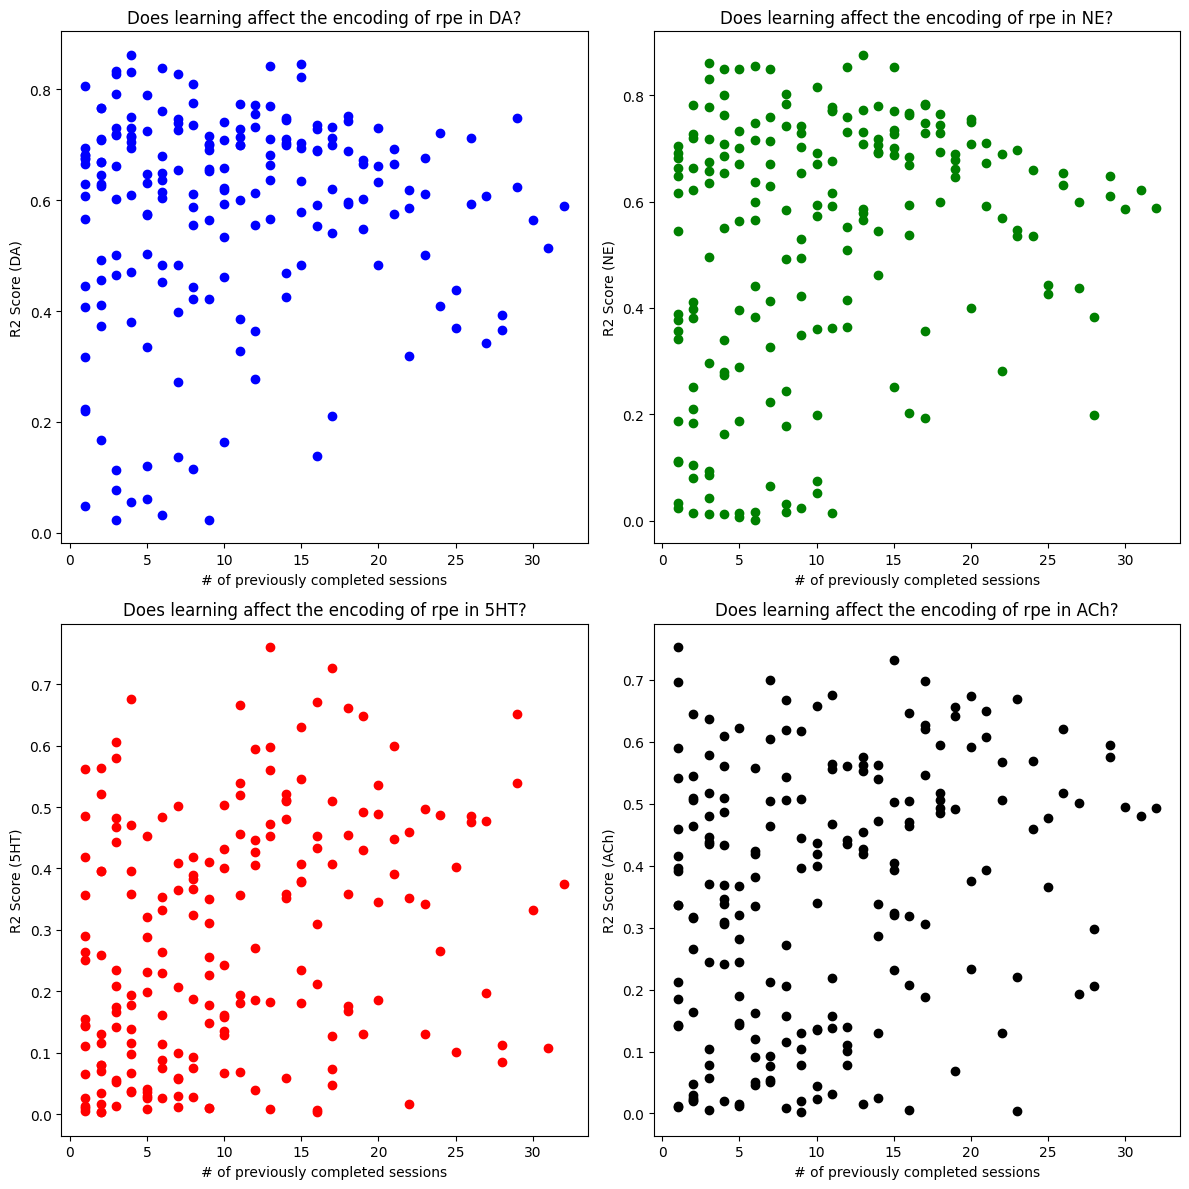

In [35]:
plot_r2_vs_sessions(df_sessions_rpe,['DA', 'NE', '5HT', 'ACh'])

### 2. Plot all NMs together

Text(0.5, 1.0, 'Does learning affect the encoding of rpe in different NMs?')

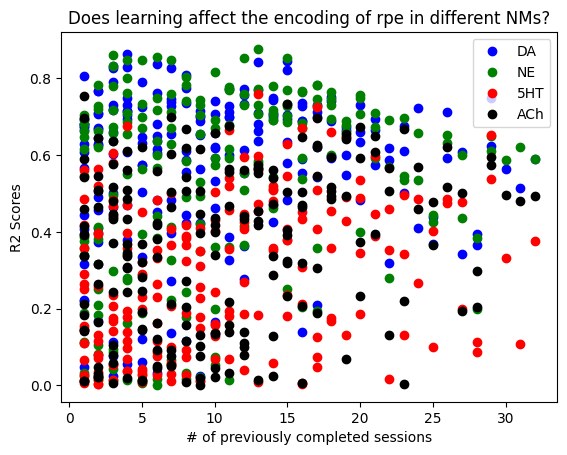

In [36]:
# combined plot
plt.plot(df_sessions_rpe['ses_idx_count'], df_sessions_rpe['DA_R2_rpe'],'bo', label='DA')
plt.plot(df_sessions_rpe['ses_idx_count'], df_sessions_rpe['NE_R2_rpe'],'go' ,label='NE')
plt.plot(df_sessions_rpe['ses_idx_count'], df_sessions_rpe['5HT_R2_rpe'],'ro', label='5HT')
plt.plot(df_sessions_rpe['ses_idx_count'], df_sessions_rpe['ACh_R2_rpe'], 'ko', label='ACh')

plt.xlabel('# of previously completed sessions')
plt.ylabel('R2 Scores')
plt.legend()
plt.title('Does learning affect the encoding of rpe in different NMs?')


Text(0.5, 1.0, 'Does learning affect the encoding of rpe in the Neuromodulators?')

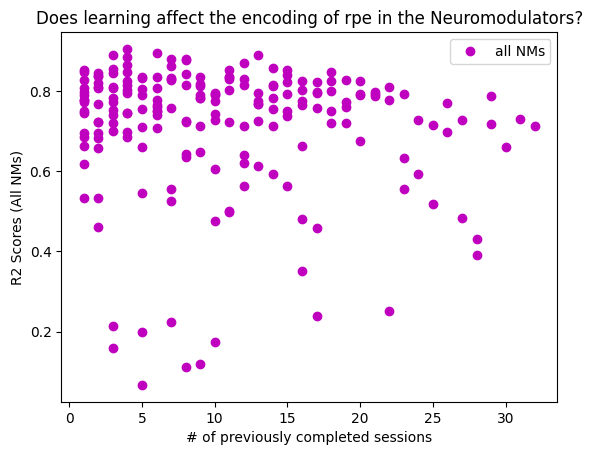

In [37]:
# plot the reconstruction scores for the combined embeddings
plt.plot(df_sessions_rpe['ses_idx_count'], df_sessions_rpe['all4_R2_rpe'],'mo', label='all NMs')

plt.xlabel('# of previously completed sessions')
plt.ylabel('R2 Scores (All NMs)')
plt.legend()
plt.title('Does learning affect the encoding of rpe in the Neuromodulators?')

## E. Quantify the correlation

In [38]:
np.cov(df_sessions_rpe['ses_idx_count'],df_sessions_rpe['ses_idx_count'])

array([[59.37920854, 59.37920854],
       [59.37920854, 59.37920854]])

Pearson correlation == covariance /product of the standard deviation of the two variables

In [39]:
# define function to compute the Pearson correlation
def get_correlation_coeff(x,y):
    return pearsonr(x,y)

In [40]:
# define loop to make comparisons over all the variables with the number of sessions

elements = ['DA_R2_rpe', 'NE_R2_rpe', '5HT_R2_rpe', 'ACh_R2_rpe', 'all4_R2_rpe']
coeffs = []

for element in elements:
    correlation, p_value = get_correlation_coeff(df_sessions_rpe[element], df_sessions_rpe['ses_idx_count'])
    coeffs.append(correlation)

coeffs = np.array(coeffs)

Text(0.5, 1.0, 'Comparison of the correlation coefficients')

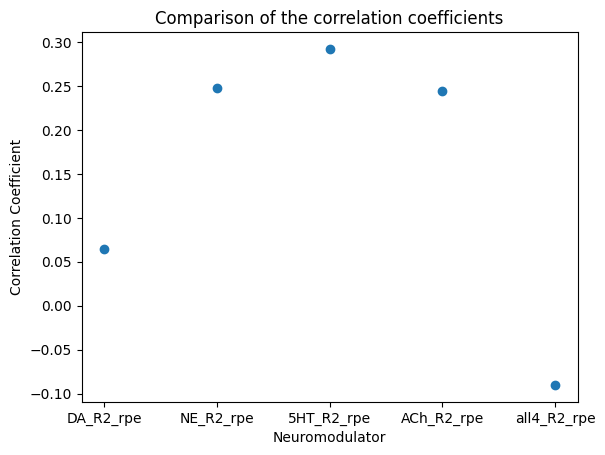

In [41]:
plt.plot(elements,coeffs,'o')
plt.xlabel('Neuromodulator')
plt.ylabel('Correlation Coefficient')
plt.title('Comparison of the correlation coefficients')

Do this but at the level of each mouse

In [42]:
grouped = df_sessions_rpe.groupby('subject_ID')

In [43]:
# Define a function to compute correlation for each group
def compute_correlation(group):
    result = {}
    for element in elements:
        if group[element].count() < 2 or group['ses_idx_count'].count() < 2:
            result[element] = np.nan
        else:
            correlation, p_value = pearsonr(group[element], group['ses_idx_count'])
            result[element] = correlation
    return pd.Series(result)

In [44]:
corr_results = df_sessions_rpe.groupby('subject_ID').apply(compute_correlation).reset_index()

In [45]:
# dataframe with results of the correlation coeffs of the different embeddings with the number of completed
# sessions, grouped by mouse
corr_results

,subject_ID,DA_R2_rpe,NE_R2_rpe,5HT_R2_rpe,ACh_R2_rpe,all4_R2_rpe
0,631198,-0.482585,-0.653180,0.317170,-0.036049,-0.322295
1,631199,0.870285,0.900267,0.572375,-0.230097,0.431732
2,632103,-1.000000,-1.000000,1.000000,-1.000000,-1.000000
3,632104,-0.268345,-0.231726,-0.050182,0.115272,-0.189730
4,632105,0.332168,0.480044,0.547127,0.490072,0.186772
5,632106,0.173692,0.286997,-0.059733,-0.448096,-0.103220
6,632107,NaN,NaN,NaN,NaN,NaN
7,632110,0.729208,-0.652269,0.936778,-0.567936,0.338128
8,634704,0.101833,0.045641,0.411264,0.208193,0.119990
9,637701,0.141327,0.250857,-0.024849,0.193475,0.095362


In [46]:
ind_r2_means = np.array(df_sessions_rpe.loc[:,['DA_R2_rpe', 'NE_R2_rpe', '5HT_R2_rpe', 'ACh_R2_rpe', 'all4_R2_rpe']].mean())

In [47]:
ind_r2_means

array([0.58052106, 0.5264953 , 0.28220532, 0.35305682, 0.7160477 ])

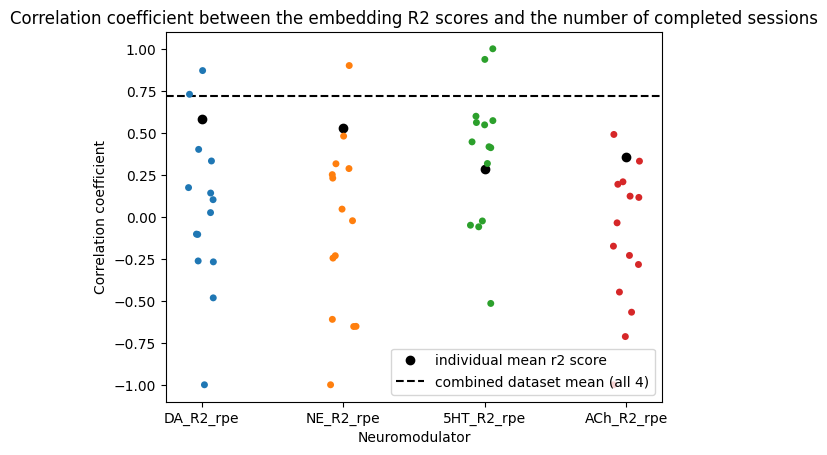

In [48]:
sns.stripplot(data=corr_results.loc[:,['DA_R2_rpe', 'NE_R2_rpe', '5HT_R2_rpe', 'ACh_R2_rpe']])
plt.plot(ind_r2_means[:4], 'ko', label='individual mean r2 score')
plt.axhline(np.round(ind_r2_means[4],2), linestyle='--', c='k', label='combined dataset mean (all 4)')
plt.xlabel('Neuromodulator')
plt.ylabel('Correlation coefficient')
plt.title('Correlation coefficient between the embedding R2 scores and the number of completed sessions')
plt.legend()